In [1]:
%pylab inline

import keras
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# SOPH: review these params and update accordingly
img_rows = 28
img_cols = 28
channels = 1
num_classes = 10
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

In [6]:
# x_train should be [n_examples x pixels x pixels]
# y_train should be [n_examples x n_labels]
# Load the dataset
(X_train, y_train), (_, _) = keras.datasets.mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3) # add channel dimension for mnist data
y_train = y_train.reshape(-1, 1)



In [7]:
def plot_images(x, y, **kwargs):
    n_pix = int(np.sqrt(np.prod(x.shape[1:3]))) #assumes images are square
    im_indices = np.random.choice(x.shape[0], 36, replace=False)
    fig, axes = subplots(nrows=6,ncols=6, figsize=(6,6), sharex=True, sharey=True, frameon=False)
    for i,ax in enumerate(axes.flat):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        curr_i = im_indices[i]
        ax.imshow(x[curr_i].reshape(n_pix,n_pix), aspect="auto", cmap="gray", **kwargs)
        ax.text(3,5,y[curr_i], fontdict={"backgroundcolor": "gray","color": "white", "size":"8" })
#         ax.set_title(title)
        ax.axis('off')
    plt.tight_layout(h_pad=0, w_pad=0)

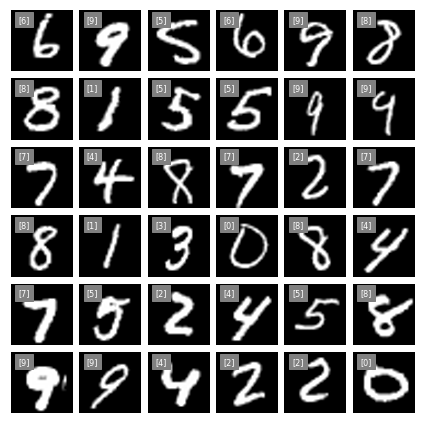

In [8]:
plot_images(X_train, y_train, interpolation="spline16")

In [25]:
# build discriminator

DROP = .25

img = keras.Input(shape=img_shape)

conv = keras.Sequential([
    keras.layers.InputLayer(input_shape=img_shape),
    
    keras.layers.Conv2D(32, 3, padding="same", activation="elu"),
    keras.layers.Conv2D(32, 3, strides=2, padding="same", activation="elu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(DROP),
    
    keras.layers.Conv2D(32, 3, padding="same", activation="elu"),
    keras.layers.Conv2D(32, 3, strides=2, padding="same", activation="elu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(DROP),
    
    keras.layers.Conv2D(64, 3, padding="same", activation="elu"),
    keras.layers.Conv2D(64, 3, strides=2, padding="same", activation="elu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(DROP),
    
    keras.layers.Conv2D(64, 3, padding="same", activation="elu"),
    keras.layers.Conv2D(64, 3, strides=2, padding="same", activation="elu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(DROP),
    
    keras.layers.Flatten(),
])
conv.summary()
img_embedding = conv(img)

# Discriminator
validity = keras.layers.Dense(1, activation='sigmoid')(img_embedding)

label = keras.layers.Dense(num_classes+1, activation='softmax')(img_embedding)

disk = keras.Model(img, [validity, label])

disk.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 32)          9248      
__________

In [26]:
optimizer = keras.optimizers.Adam(0.0002, 0.5)
losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

# Build and the discriminator and recognition network

disk.compile(loss=losses,
    optimizer=optimizer,
    metrics=['accuracy'])


In [27]:
DROP = .15

generator = keras.Sequential([
    keras.layers.Dense(4*4*32, activation="elu", input_dim=latent_dim),
    keras.layers.Reshape((4, 4, 32)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(DROP),
    
    keras.layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="elu"),
    keras.layers.Conv2D(32, 3, padding="same", activation="elu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(DROP),
    
    keras.layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="elu"),
    keras.layers.Conv2D(64, 3, padding="valid", activation="elu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(DROP),
    
    keras.layers.Conv2DTranspose(128, 5, strides=2, padding="same", activation="elu"),
    keras.layers.Conv2D(128, 5, padding="same", activation="elu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(.05),
    
    keras.layers.Conv2D(channels, 5, padding="same", activation="tanh"),
    
])


generator.summary()

noise = keras.Input(shape=(latent_dim,))
label = keras.Input(shape=(1,), dtype='int32')
label_embedding = keras.layers.Flatten()(
    keras.layers.Embedding(num_classes, 100)(label))

model_input = keras.layers.multiply([noise, label_embedding])
img = generator(model_input)

gen = keras.Model([noise, label], img)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               51712     
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 32)          0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 4, 4, 32)          128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 8, 32)          128       
__________

In [28]:
# For the combined model we will only train the generator
disk.trainable = False

# The discriminator takes generated image as input and determines validity
valid, target_label = disk(img)

# The combined model  (stacked generator and discriminator)
combined = keras.Model([noise, label], [valid, target_label])
combined.compile(loss=losses, optimizer=optimizer)

In [29]:
def sample_generator_input(batch_size):
    # Generator inputs
    sampled_noise = np.random.normal(0, 1, (batch_size, 90))


    # generates random combinations of your labels so that it can generate randomized images
    sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
    sampled_labels = keras.utils.to_categorical(sampled_labels, num_classes=num_classes)

    return sampled_noise, sampled_labels


def sample_images(epoch, **kwargs):
    r, c = 10, 10
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.array([num for _ in range(r) for num in range(c)])
    gen_imgs = gen.predict([noise, sampled_labels])
    # Rescale images 0 - 1
    gen_imgs = (0.5 * gen_imgs + 0.5)*255
    gen_imgs = gen_imgs.astype("uint8")
    
    fig, axes = subplots(nrows=r,ncols=c, figsize=(6,6), sharex=True, sharey=True, frameon=False)
    for i,ax in enumerate(axes.flat):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(gen_imgs[i,:,:,0], aspect="auto", cmap="gray", **kwargs)
        ax.text(3,5,sampled_labels[i], fontdict={"backgroundcolor": "gray","color": "white", "size":"6"})
#         ax.set_title(title)
        ax.axis('off')
    
    fig.savefig("images/%05d.png" % epoch,dpi=150, bbox_inches="tight")
    plt.close()

def save_model():

    def save(model, model_name):
        model_path = "saved_model/%s.json" % model_name
        weights_path = "saved_model/%s_weights.hdf5" % model_name
        options = {"file_arch": model_path,
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])

    save(generator, "generator")
    save(discriminator, "discriminator")

In [30]:
sample_images(0)

In [ ]:
batch_size = 128
sample_interval = 100
epochs = 10000
smooth = 0


# Adversarial ground truths
valid = np.ones((batch_size, 1))*(1-smooth)
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Sample noise as generator input
    noise = np.random.normal(0, 1, (batch_size, 100))

    # The labels of the digits that the generator tries to create an
    # image representation of
    sampled_labels = np.random.randint(0, 10, (batch_size, 1))

    # Generate a half batch of new images
    gen_imgs = gen.predict([noise, sampled_labels])

    # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
    img_labels = y_train[idx]
    fake_labels = 10 * np.ones(img_labels.shape)

    # Train on real and generated data
    d_loss_real = disk.train_on_batch(imgs, [valid, img_labels])
    d_loss_fake = disk.train_on_batch(gen_imgs, [fake, fake_labels])

    # Avg. loss
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator and Q-network
    # ---------------------

    g_loss = combined.train_on_batch([noise, sampled_labels],
                                     [valid, sampled_labels])

    # Plot the progress

    # If at save interval => save generated image samples
    if epoch % sample_interval == 0:
        print(
            f"{epoch//sample_interval:d} [D loss: {d_loss[0]:f}, acc.: {d_loss[3]:.2%}, op_acc: {d_loss[4]:.2%}] [G loss: {g_loss[0]:f}]"
        )
        sample_images(epoch // sample_interval)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 4.611968, acc.: 51.56%, op_acc: 7.42%] [G loss: 4.416356]
1 [D loss: 1.067275, acc.: 71.88%, op_acc: 79.30%] [G loss: 12.209232]
2 [D loss: 1.552919, acc.: 56.25%, op_acc: 72.66%] [G loss: 5.383598]
3 [D loss: 1.284629, acc.: 65.62%, op_acc: 78.91%] [G loss: 6.427123]
4 [D loss: 1.114822, acc.: 73.05%, op_acc: 78.52%] [G loss: 6.722362]
5 [D loss: 0.885477, acc.: 85.16%, op_acc: 83.20%] [G loss: 6.611559]
